# Classification
The aim of this section is to apply supervised learning methods to create a classification model to determine if tweets are an actual emergency. With this model, depending on success, could be used to predict a variety of other themes, given the appropriate class labelling. The class label have already been pre-labellel under the column _target_, and shows 1 if the tweet has been classified as an emergency, and 0 if not. The original [file can be seen here](/tweets-raw.csv).

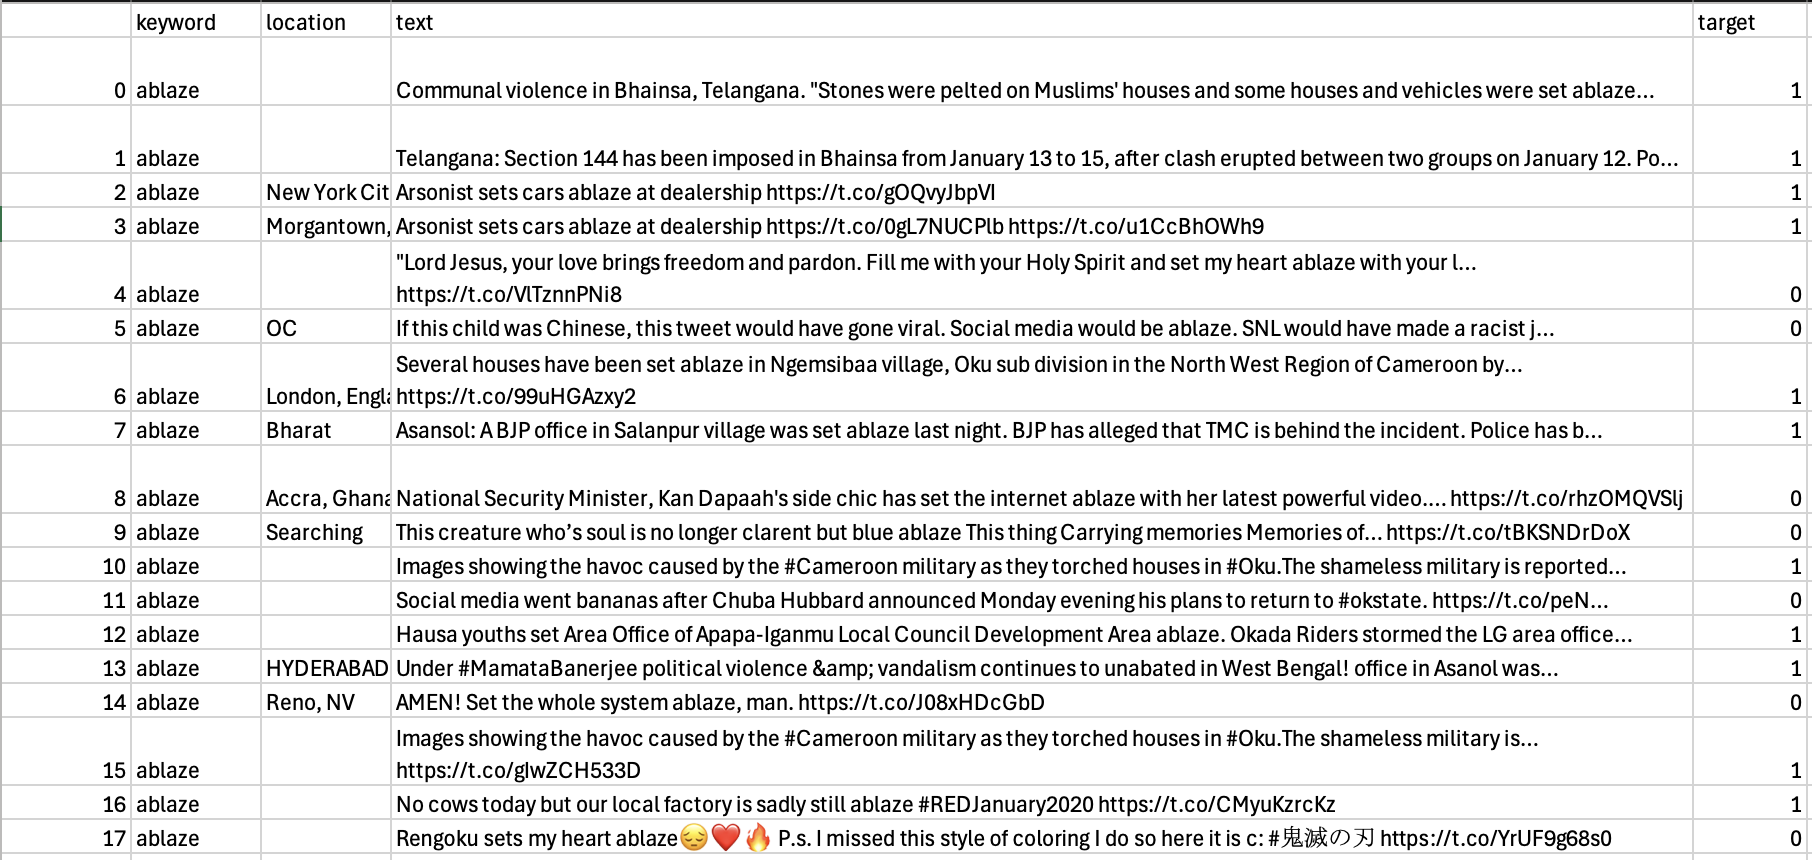

It is important to preface that this dataset faces the classic class imbalance problem, given that emergency tweets (1) constitutes only 18.5% of records before cleaning. Hence, there will need to be techniques applied to account for class imbalances. For instance, F1-score is more telling than Accuracy measures. We chose to oversample instead of undersample as it would mean disposing of 7k more records of non-emergencies(0), which would mean an even smaller training set after cleaning. 

Here is the order you will expect as you read the rest of this report:
1. [Data pre-processing](#1-data-preprocessing). The tweets are seen as is. For example, besides the actual text, emojis, vulgarities, hashtags are present with varying characters. Location range from actual values such as United States of America to "hell" or "jesus". 
2. [Dataset splitting](#2-dataset-splitting). We will need a training set, and a test set. We have decided to employ the holdout method, which uses 2/3 of the data for model training. 
3. [Feature engineering](#3-feature-engineering-using-tf-idf). The keyword column, which contain the "emergency" word in the sentence, will be added to the feature list. The sentences will be tokenised and vectorised using a Term Frequency-Inverse Document Frequency (TF-IDF) approach.
4. [Resolving class imbalances](#4-resolving-class-imbalances). Oversampling is conducted here, after vectorisation, to reduce disparity between negative and positive classes.
5. [Model selection](#5-model-selection). We attempted to use various classifiers. They were support vector classification, logistic regression, Naïve (Complement) Baynesian Classification and KNN. We also considered decision tree induction, and the ensemble methods, bagging and boosting via AdaBoost. 
6. [Training phase](#6-training-phase). Models will be applied on the sentences. 
7. [Evaluation phase](#7-evaluation-phase). Here, we will apply metrics using the confusion matrix, and evaluate the F1-score. A sample run is conducted in the final portion.


## 0. Install libraries

In [1]:
! pip install scikit-learn
! pip install nltk
! pip install imblearn

## 1. Data Preprocessing

In this phase, we remove punctuations and emojis. Though we are aware that this might affect sentence semantics, especially if we choose to adopt encoder-only transformers, it is relatively easy to roll back. For now, emojis and punctuation will not be considered.

We also realised it was important to remove stop words, numbers, and undergo lemmasation (removing of _-ings_). Source: Web Data Mining, Bing Liu

In [2]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('tweetsv2.csv')

# Here, we can see that we have a imbalanced data set, with over 3 times the count of non-emergency tweets compared to emergency ones
df['target'].value_counts()

target
0    9256
1    2114
Name: count, dtype: int64

In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure nltk resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Read the CSV file
df = pd.read_csv('tweetsv2.csv')

# Emoji removal source
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)  # Remove all digits

def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)  # Remove URLs starting with http, https, or www

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs, emojis, punctuation, and numbers
    text = remove_urls(remove_emojis(remove_punctuation(remove_numbers(text))))
    # Tokenize the text
    tokens = text.split()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin the tokens into a single string
    return ' '.join(tokens)

# Apply preprocessing to the 'text' column
df['cleantweet'] = df['text'].apply(lambda x: preprocess_text(str(x)))

# Display the cleaned data
print(df['cleantweet'][0])
display(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


communal violence bhainsa telangana stone pelted muslim house house vehicle set ablaze


,Unnamed: 0,keyword,location,text,text.1,url (without https://),target,cleantweet
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...","Communal violence in Bhainsa, Telangana. ""Ston...",NaN,1,communal violence bhainsa telangana stone pelt...
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,Telangana: Section 144 has been imposed in Bha...,NaN,1,telangana section imposed bhainsa january clas...
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,Arsonist sets cars ablaze at dealership,t.co/gOQvyJbpVI,1,arsonist set car ablaze dealership
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,#SPILL!,NaN,1,arsonist set car ablaze dealership
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...","""Lord Jesus, your love brings freedom and pard...",t.co/VlTznnPNi8,0,lord jesus love brings freedom pardon fill hol...


## 2. Dataset splitting

In [4]:
from sklearn.model_selection import train_test_split

X = df['cleantweet']
y = df['target']
len(X)
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 33)
len(X_test)

3753

## 3. Feature Engineering using TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)  # Vectorize the training set
X_test_vec = vectorizer.transform(X_test)       # Vectorize the test set

## 4. Resolving class imbalances

In [6]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=33)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_vec, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


## 5. Model selection

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
# Naive Bayes Classification treats each document like a "bag of words", making assumptions 
# of word independence against other words, and against word position. Source: Web Data Mining, Bing Liu
from sklearn.svm import LinearSVC
# Linear Support Vector Machines attempts to find the maximal margin decision boundary to separate positive and 
# negative examples (Liu, 1998). Since we have binary classification, it's an optimal approach. It also works 
# well for categorical values, compared to numerical ones for Linear Regression Classifiers.
from sklearn.neighbors import KNeighborsClassifier
# K-Nearest neighbour works by assigning the test input with the most frequent class of the k neighbours 
# nearest to it

from sklearn.metrics import accuracy_score

## 6. Training phase

With the dropping of stop words, performance improvements were seen. 

In the beginning:
MNB: 0.846
CNB: 0.867
SVC: 0.894

After stop-words dropped:
MNB: 0.857
CNB: 0.879
SVC: 0.895

After oversampling: 
MNB: 0.829
CNB: 0.829
SVC: 0.874


In [8]:
# Multinomial Naive Bayes
pipeline_MNB = Pipeline([('clf', MultinomialNB())])
pipeline_MNB.fit(X_train_resampled, y_train_resampled)
predictMNB = pipeline_MNB.predict(X_test_vec)
print(f"MNB: {accuracy_score(y_test, predictMNB):.3f}")

# Complement Naive Bayes
pipeline_CNB = Pipeline([('clf', ComplementNB())])
pipeline_CNB.fit(X_train_resampled, y_train_resampled)
predictCNB = pipeline_CNB.predict(X_test_vec)
print(f"CNB: {accuracy_score(y_test, predictCNB):.3f}")

# Linear SVC
pipeline_SVC = Pipeline([('clf', LinearSVC())])
pipeline_SVC.fit(X_train_resampled, y_train_resampled)
predictSVC = pipeline_SVC.predict(X_test_vec)
print(f"SVC: {accuracy_score(y_test, predictSVC):.3f}")

# K-Nearest Neighbors (KNN)
pipeline_KNN = Pipeline([('clf', KNeighborsClassifier())])
pipeline_KNN.fit(X_train_resampled, y_train_resampled)
predictKNN = pipeline_KNN.predict(X_test_vec)
print(f"KNN: {accuracy_score(y_test, predictKNN):.3f}")


MNB: 0.829
CNB: 0.829
SVC: 0.874
KNN: 0.869


### Attempted run using Decision Tree classifier, with significantly longer execution time of >2min5seconds
Lower accuracy likely due to skewed data distribution. Oversampling recommended due to likelihood of a few leaves being labeled as 'emergency'.

    Accuracy of decision tree: 0.809 (after oversampling) from 0.850 (without stop words) from 0.838 (with stop-words)
    Accuracy of Bagging (Decision Tree): 0.824
    Accuracy with AdaBoost (Decision Tree): 0.821

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

# Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=1)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test_vec)
print(f"Decision Tree (DT): {accuracy_score(y_test, y_pred):.3f}")

# Bagging with Decision Tree Classifier
bagging_pipeline = Pipeline([('bagging', BaggingClassifier(DecisionTreeClassifier(random_state=1), random_state=1))])
bagging_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_bagging = bagging_pipeline.predict(X_test_vec)
print(f"Bagging (Decision Tree): {accuracy_score(y_test, y_pred_bagging):.3f}")

# Boosting with AdaBoost
ada_boost_pipeline = Pipeline([('adaboost', AdaBoostClassifier(DecisionTreeClassifier(random_state=1), random_state=1))])
ada_boost_pipeline.fit(X_train_resampled, y_train_resampled)
y_pred_ada_boost = ada_boost_pipeline.predict(X_test_vec)
print(f"AdaBoost (Decision Tree): {accuracy_score(y_test, y_pred_ada_boost):.3f}")

Decision Tree (DT): 0.809
Bagging (Decision Tree): 0.824
AdaBoost (Decision Tree): 0.821


### Attempt using logistic regression
Execution time: 3.3s 
Accuracy: 0.866 (after oversampling) from 0.875 (without stop words) from 0.850 (with stop-words)

In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0)
clf.fit(X_train_resampled, y_train_resampled)

y_pred = clf.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.866


## 7. Evaluation phase
Given that our dataset is skewed, accuracy as a measure may be less accurate. 

Let's see our classification report for the most "accurate" classifier when the data was not oversampled, and hence, imbalanced.

                    precision    recall  f1-score   support

                0       0.92      0.96      0.94      3064
                1       0.77      0.61      0.68       689

         accuracy                           0.90      3753
        macro avg       0.84      0.79      0.81      3753
     weighted avg       0.89      0.90      0.89      3753


- Precision is the number of **correctly classified positive** examples _divided_ by the total number of examples classified as positive. 
    - In other words, precision = 0.92 for 0 (non-emergency) means 92% of the messages classified as non-emergency are actually non-emergencies. 
    - Precision = 0.77 means for 1 (emergency) means 77% of the messages classified as emergencies are truly emergencies.

- Recall is the number of **correctly classified positive** examples _divided_ by the total number of actual positives in the test set. 
    - In other words, recall = 0.96 for 0 (non-emergency) means that 96% of the actual non-emergency messages were correctly identified.
    - For 1 (emergency), only 61% of the actual emergency messages were identified correctly.

- F1-score is the **harmonic mean of precision and recall**, balancing the two.
    - An F1 = 0.94 indicates strong performacne for 0 (non-emergency).
    - An F1 = 0.68 indicates moderately good performance but room for improvement for 1 (emergency).
    - Though it might be tempting to conclude that the lower F1-score for class 1 reflects that the model’s recall, the support reminds us that the data set is pretty skewed. 

Now, the result we see below is after oversampling. **Why did precision decrease and recall increase?** Precision decreased because oversampling increases false positives (more non-emergencies classified as emergencies). Recall increased because the model had more examples of emergencies to learn from, reducing false negatives.


In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictSVC))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3064
           1       0.65      0.68      0.66       689

    accuracy                           0.87      3753
   macro avg       0.79      0.80      0.79      3753
weighted avg       0.88      0.87      0.88      3753



## Confusion Matrix

Used to construct the classification report. Where 0 is positive, 1 is negative. 

$$
Precision (0) = \frac{2812}{(2812 + 221)} = 0.927 = 0.93
$$

$$
Recall (0) = \frac{2812}{(2812 + 252)} = 0.917 = 0.92
$$

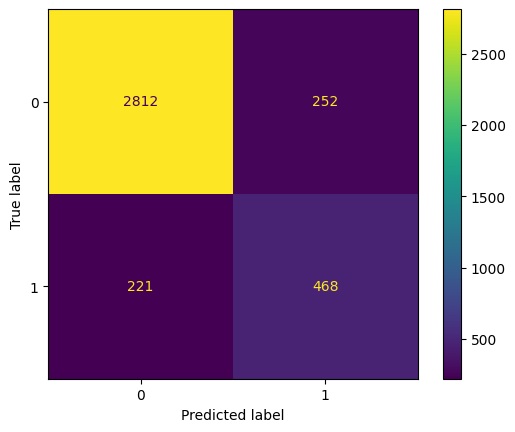

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictSVC)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()
plt.show()

## Sample run using Support Vector Classifier
Are we satisfied?

Overall, given that the necessary precautions eg. oversampling, preprocessing, trying varying classifiers were taken, we're pretty proud of our model. In terms of F1-score, we can see that there is still room for improvement. For emergency tweets, the model is still not good enough to classify an emergency tweet as a true emergency. For example, the classification of messages 1-3 are correct, but message 4 can be considered an emergency message, but it is not classified as one. This is likely due to the natural imbalance of the data set. With more examples of emergency tweets to match up with the nearly 3x more non-emergency tweets, we can achieve better classification. 

In [13]:
msg = "Severe weather expected in Lyon, France"
outcome = pipeline_SVC.predict(vectorizer.transform([msg]))
print('class label is ' + str(outcome))

msg2 = "Serious problem of scrolling too much instagram in my toilet"
outcome = pipeline_SVC.predict(vectorizer.transform([msg2]))
print('class label is ' + str(outcome))

msg3 = "Intense flying cow expected in Lyon"
outcome2 = pipeline_SVC.predict(vectorizer.transform([msg3]))
print('class label is ' + str(outcome2))

msg4 = "Climbers lost on hike, uncontactable by friends"
outcome = pipeline_SVC.predict(vectorizer.transform([msg4]))
print('class label is ' + str(outcome))

class label is [1]
class label is [0]
class label is [0]
class label is [0]
